In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(Sierra)
library(presto)
library(ggplot2)
library(msigdbr)
library(fgsea)
library(Seurat)
library(tidyverse)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
"replacing previous import 'GenomicRanges::union' by 'dplyr::union' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::intersect' by 'dplyr::intersect' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::setdiff' by 'dplyr::setdiff' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::tail' by 'utils::tail' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::head' by 'utils::head' when loading 'Sierra'"
Loading required package: Rcpp

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Registered S3 method overwritten by 'cli':
  method     f

In [2]:
setwd('/home/aiden/codes/APA_stuff/post_qual/APA')

In [9]:
ge_so <- readRDS('rdata/ge_all_in_so.rds')

In [12]:
peak.annotations <- read.table("/data/APAproject//post_qual/data/Alexandra_Grubman/Sierra_outs_2/Alexandra_Sierra_for_annotations.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)
head(peak.annotations)

,seqnames,start,end,width,strand,gene_id,UTR3,UTR5,intron,exon,CDS,pA_motif,pA_stretch,pT_stretch,Junctions
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>
RALBP1:chr18:9475392-9517266:1,chr18,9475392,9517266,41875,+,"RALBP1,AP005432.1",,YES,YES,YES,YES,FALSE,FALSE,FALSE,across-junctions
FDFT1:chr8:11831598-11839273:1,chr8,11831598,11839273,7676,+,FDFT1,YES,,,,,FALSE,FALSE,FALSE,across-junctions
PCM1:chr8:18014452-18028219:1,chr8,18014452,18028219,13768,+,PCM1,YES,,,,,FALSE,FALSE,FALSE,across-junctions
ANKRD12:chr18:9221796-9254890:1,chr18,9221796,9254890,33095,+,ANKRD12,YES,,,,,FALSE,FALSE,FALSE,across-junctions
SUPT20H:chr13:37009312-37012363:-1,chr13,37009312,37012363,3052,-,SUPT20H,YES,,,,,FALSE,FALSE,FALSE,across-junctions
C11orf58:chr11:16752670-16755538:1,chr11,16752670,16755538,2869,+,C11orf58,YES,,,,,FALSE,FALSE,FALSE,across-junctions


In [14]:
APA.peak.annotations <- peak.annotations %>% filter(UTR3=='YES')
dim(APA.peak.annotations)

[1] 28532    15

In [30]:
dim(unique(APA.peak.annotations['gene_id']))

[1] 12497     1

In [15]:
peak.counts_2 <- ReadPeakCounts(data.dir = "/data/APAproject/post_qual/data/Alexandra_Grubman/Sierra_outs_2/Alexandra_Sierra_aggregate")
peaks_ge.so <- PeakSeuratFromTransfer(peak.data = peak.counts_2, 
                                       genes.seurat = ge_so, 
                                       annot.info = APA.peak.annotations, 
                                       min.cells = 0, min.peaks = 200)

[1] "Creating Seurat object with 27598 peaks and 13214 cells"


Warning message:
"The following arguments are not used: row.names"


[1] "Preparing feature table for DEXSeq"
[1] "t-SNE coordinates added"
[1] "UMAP coordinates added"


In [18]:
peaks_ge.so <- AddMetaData(peaks_ge.so, metadata = ge_so@meta.data)

In [3]:
process_pca <- function (so, n_features){
    so <- NormalizeData(so, normalization.method = "LogNormalize",scale.factor = 10000)
    so <- FindVariableFeatures(object = so,selection.method = "vst", nfeatures = n_features)
    so <- ScaleData(so, features = rownames(so))
    so <- RunPCA(so, features = VariableFeatures(object = so))
    return(so)
}
peaks_so <- process_pca(peaks_ge.so,2000)

An object of class Seurat 
113733 features across 13214 samples within 1 assay 
Active assay: RNA (113733 features, 1000 variable features)
 2 dimensional reductions calculated: pca, umap

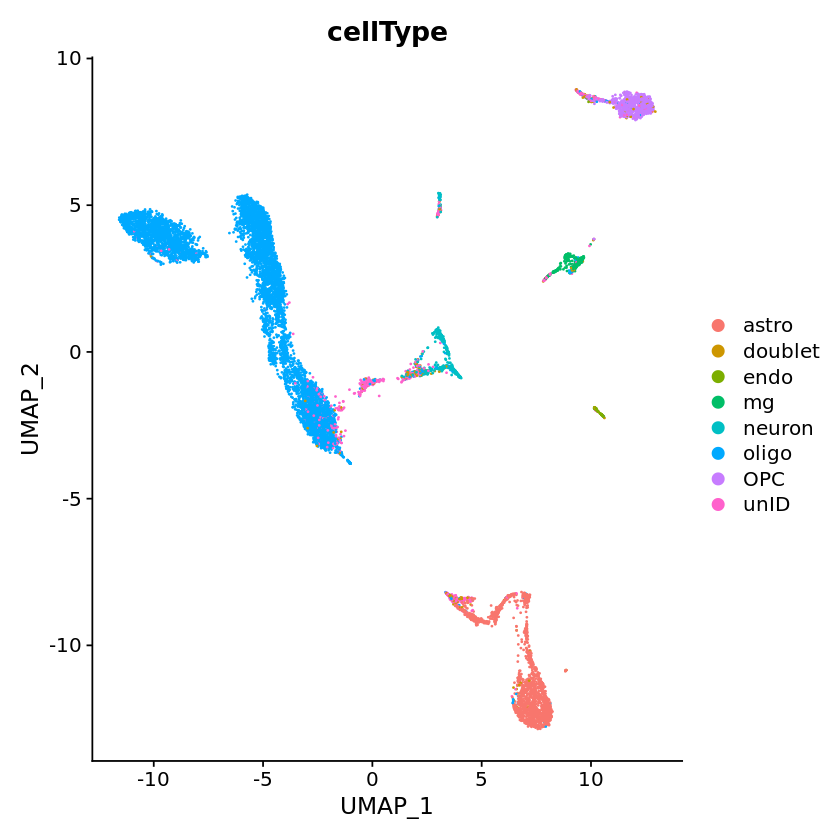

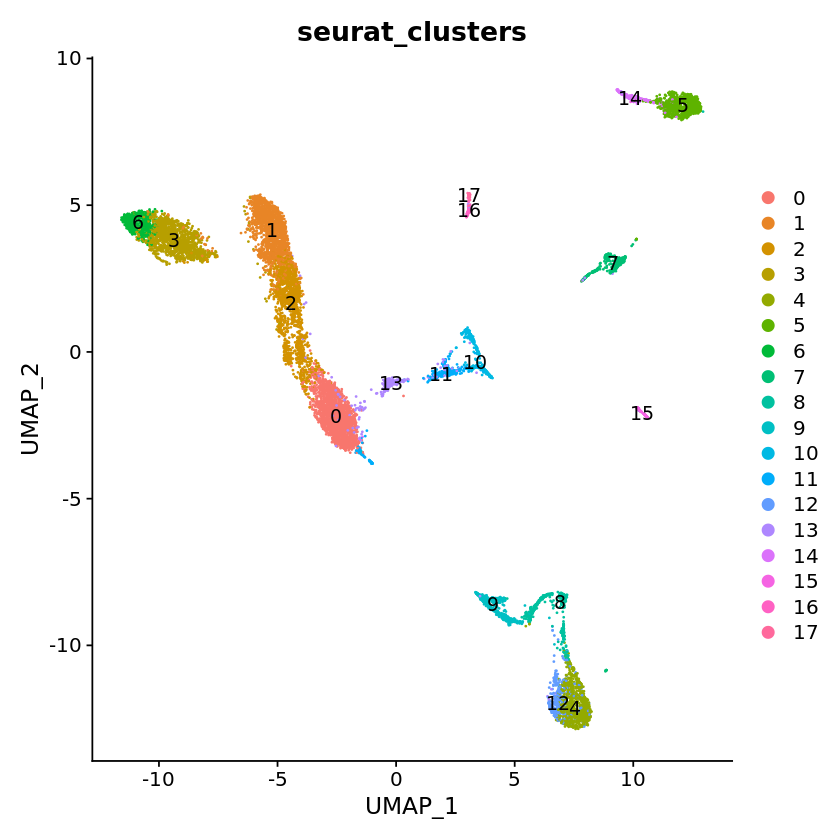

In [32]:
DimPlot(peaks_ge.so, reduction='umap', group.by='cellType')
DimPlot(peaks_ge.so, reduction='umap', group.by='seurat_clusters', label = T)

In [33]:
peaks_ge.so <- SetIdent(peaks_ge.so, value = peaks_so$seurat_clusters)

In [41]:
res.table = DUTest(peaks_ge.so, 
                   population.1 = "3", 
                   exp.thresh = 0.1)

[1] "716 expressed peaks in feature types UTR3, exon"
[1] "111 genes detected with multiple peak sites expressed"
[1] "259 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


In [42]:
res.table

,gene_name,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MBP:chr18:76978827-76979136:-1,MBP,UTR3,0.50880759,0.52307827,2.562677e-165,6.637332e-163,-0.9247608
MBP:chr18:77016135-77016574:-1,MBP,UTR3,0.50203252,0.20137859,9.564228e-111,1.238567e-108,0.8358091
GPM6B:chrX:13773938-13774416:-1,GPM6B,UTR3,0.48306233,0.35468109,5.309880e-43,4.584197e-41,0.4457306
ATP1B1:chr1:169132262-169132722:1,ATP1B1,UTR3,0.13821138,0.18227031,4.280267e-36,2.771473e-34,-1.1799575
MBP:chr18:76987535-76988030:-1,MBP,UTR3,0.28048780,0.11273013,9.684721e-32,5.016686e-30,0.7368309
TMEM144:chr4:158254781-158255369:1,TMEM144,UTR3,0.15989160,0.12503272,2.927333e-31,1.263632e-29,-0.8910761
SPP1:chr4:87982498-87982950:1,SPP1,UTR3,0.33672087,0.11866329,1.718315e-30,5.563045e-29,0.6473010
CIRBP:chr19:1272756-1273194:1,CIRBP,UTR3,0.17682927,0.11464968,2.380369e-30,6.850172e-29,1.0389481
GPM6B:chrX:13770939-13771407:-1,GPM6B,UTR3,0.16734417,0.22851409,6.192203e-28,1.603781e-26,-0.7942493


In [43]:
overall_DUT_result_top <- subset(res.table, abs(Log2_fold_change) > 1)
overall_DUT_result_top

,gene_name,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATP1B1:chr1:169132262-169132722:1,ATP1B1,UTR3,0.1382114,0.1822703,4.280267e-36,2.771473e-34,-1.179957
CIRBP:chr19:1272756-1273194:1,CIRBP,UTR3,0.1768293,0.1146497,2.380369e-30,6.850172e-29,1.038948


[1] "ATP1B1:chr1:169132262-169132722:1" "ATP1B1:chr1:169131132-169131864:1"
[3] "ATP1B1:chr1:169127284-169131880:1" "ATP1B1:chr1:169129904-169131879:1"


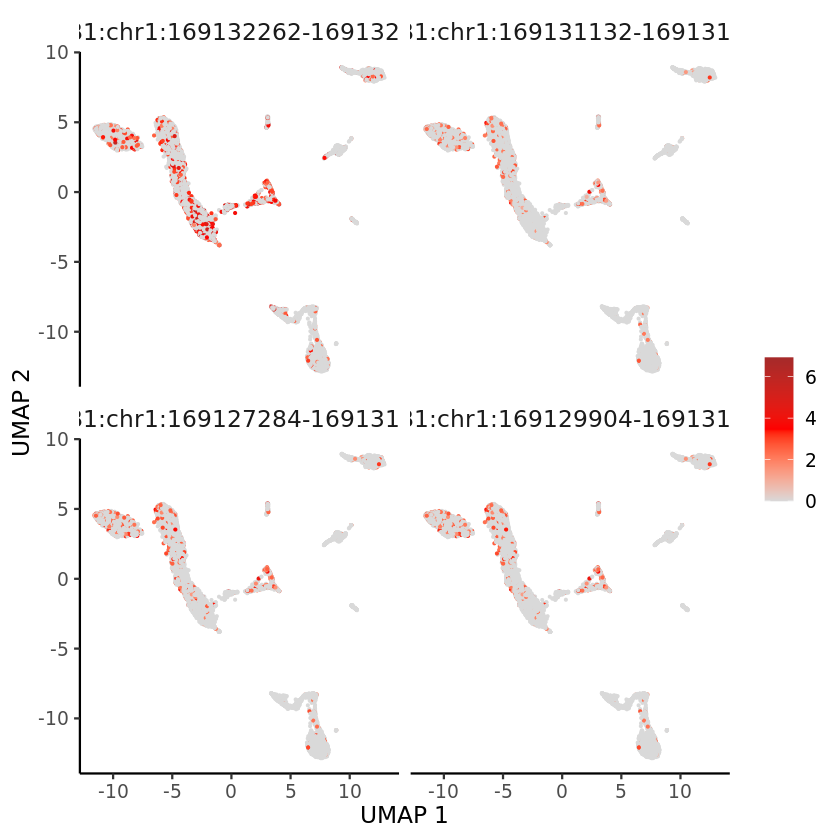

In [45]:
peaks.to.plot <- rownames(subset(res.table, gene_name == "ATP1B1"))
print(peaks.to.plot)
PlotRelativeExpressionUMAP(peaks_ge.so, peaks.to.plot = peaks.to.plot)

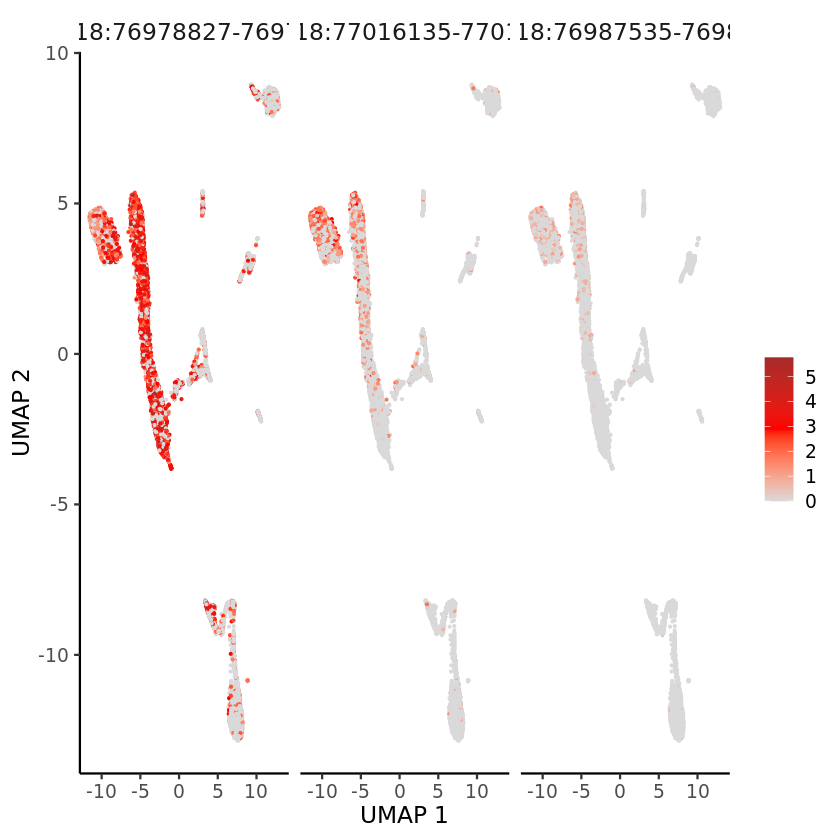

In [40]:
PlotRelativeExpressionUMAP(peaks_ge.so, peaks.to.plot = peaks.to.plot)